In [2]:
from bitarray import bitarray
from hashlib import sha3_256, sha256, blake2b
import string
import json
import matplotlib.pyplot as plt

In [3]:
# 1a. Implementing and Populate a Bloom Filter
# set the Bloom filter size (in bits)
size = int(1e7)    # about 1.25 MB
# implement the filter
bloom = bitarray(size)
bloom.setall(False)

def my_hash(s):
    return int(sha256(s.lower().encode()).hexdigest(), 16) % size

def my_hash2(s):
    return int(blake2b(s.lower().encode()).hexdigest(), 16) % size

def my_hash3(s):
    return int(sha3_256(s.lower().encode()).hexdigest(), 16) % size

with open("data/words.txt", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        # check whether the current word is empty
        if not word:
            continue
        # compute indices for each hash and set those bits
        idx1 = my_hash(word)
        idx2 = my_hash2(word)
        idx3 = my_hash3(word)
        bloom[idx1] = True
        bloom[idx2] = True
        bloom[idx3] = True

In [4]:
# 1b. Spell Check and Correction
alphabet = string.ascii_lowercase

def bf_contains(word, bloom, hash_funcs):
    w = word.lower()
    return all(bloom[h(w)] for h in hash_funcs)

def spell_check(word, bloom, hash_funcs, alphabet=alphabet):
    word = word.lower()
    suggestions, seen = [], set()
    for i, ch0 in enumerate(word):
        for ch in alphabet:
            if ch == ch0:
                continue
            cand = word[:i] + ch + word[i+1:]
            if cand in seen:
                continue
            seen.add(cand)
            if all(bloom[h(cand)] for h in hash_funcs):
                suggestions.append(cand)
    return suggestions

dict_words = {
    line.strip().lower()
    for line in open("data/words.txt", encoding="utf-8")
    if line.strip()
}

def evaluate(bloom, typos_path, hash_funcs, dict_words):
    with open(typos_path, 'r', encoding='utf-8') as f:
        typo_pairs = json.load(f)

    total_typos = 0
    good_suggestions = 0
    misidentified = 0
    max_suggestions=3

    for typed_word, correct_word in typo_pairs:
        typed_word = typed_word.lower()
        correct_word = correct_word.lower()

        if typed_word == correct_word:
            continue

        total_typos += 1

        # misidentified (fp): BF claims typed_word is present, but it's not in the true dictionary
        if typed_word not in dict_words and bf_contains(typed_word, bloom, hash_funcs):
            misidentified += 1

        # good suggestion: ≤3 suggestions and includes the correct word
        suggestions = spell_check(typed_word, bloom, hash_funcs)
        if len(suggestions) <= max_suggestions and correct_word in suggestions:
            good_suggestions += 1

    if total_typos == 0:
        return {"good_rate": 0.0, "misidentified_rate": 0.0, "n_typos": 0}

    return {
        "good_rate": good_suggestions / total_typos,
        "misidentified_rate": misidentified / total_typos,
        "n_typos": total_typos,
    }

In [5]:
def build_bloom(dict_words, size_bits, hash_funcs):
    b = bitarray(size_bits); b.setall(False)
    for w in dict_words:
        for h in hash_funcs:
            b[h(w)] = True
    return b

hash_funcs1 = [my_hash]
hash_funcs2 = [my_hash, my_hash2]
hash_funcs3 = [my_hash, my_hash2, my_hash3]

# Evaluate Performance
bloom1 = build_bloom(dict_words, size, hash_funcs1)
eval1  = evaluate(bloom1, "data/typos.json", hash_funcs1, dict_words)

bloom2 = build_bloom(dict_words, size, hash_funcs2)
eval2  = evaluate(bloom2, "data/typos.json", hash_funcs2, dict_words)

bloom3 = build_bloom(dict_words, size, hash_funcs3)
eval3  = evaluate(bloom3, "data/typos.json", hash_funcs3, dict_words)

print(eval1, eval2, eval3)


{'good_rate': 0.0048, 'misidentified_rate': 0.0446, 'n_typos': 25000} {'good_rate': 0.62616, 'misidentified_rate': 0.00776, 'n_typos': 25000} {'good_rate': 0.91784, 'misidentified_rate': 0.00204, 'n_typos': 25000}


k=1 bits for ≥85% good: 200000000
k=2 bits for ≥85% good: 20000000
k=3 bits for ≥85% good: 10000000


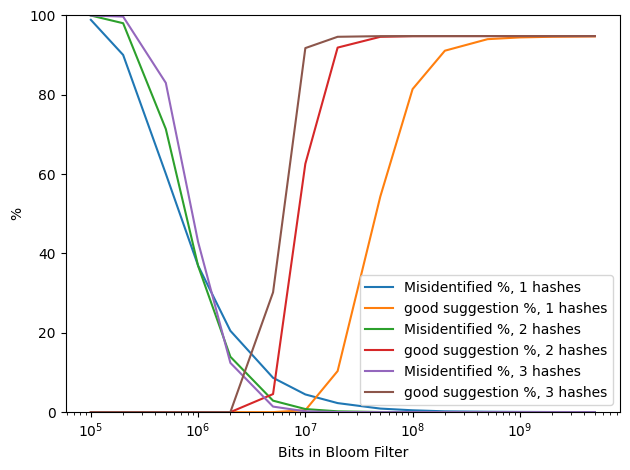

In [6]:
# 1c. Analysis and Reflection 
sizes = [int(m * 10**e) for e in range(5, 10) for m in (1, 2, 5)]
hashsets = {
    1: [my_hash],
    2: [my_hash, my_hash2],
    3: [my_hash, my_hash2, my_hash3],
}

results = {k: [] for k in (1, 2, 3)}
for k, funcs in hashsets.items():
    for m in sizes:
        size = m                      # update the global used inside my_hash
        b = build_bloom(dict_words, m, funcs)
        s = evaluate(b, "data/typos.json", funcs, dict_words)
        results[k].append({"m": m, "good": 100*s["good_rate"], "misid": 100*s["misidentified_rate"]})
        
# thresholds
for k in (1, 2, 3):
    rows = sorted(results[k], key=lambda r: r["m"])
    hit = next((r["m"] for r in rows if r["good"] >= 85.0), None)
    print(f"k={k} bits for ≥85% good: {hit if hit is not None else 'not reached'}")

# plots
plt.figure()
for k in (1, 2, 3):
    rows = sorted(results[k], key=lambda r: r["m"])
    xs = [r["m"] for r in rows]
    plt.plot(xs, [r["misid"] for r in rows], label=f"Misidentified %, {k} hashes")
    plt.plot(xs, [r["good"]  for r in rows], label=f"good suggestion %, {k} hashes")
plt.xscale("log"); plt.ylim(0, 100)
plt.xlabel("Bits in Bloom Filter"); plt.ylabel("%")
plt.legend(); plt.tight_layout()
plt.savefig('plots/1c.png', dpi=150)